# ALGORITMO GENÉTICO PARA OTIMIZAR ROTEAMENTO DE TRANSPORTE DE HIDROGÊNIO VERDE

### TODOS OS DADOS SÃO DE http://vrp.galgos.inf.puc-rio.br/index.php/en/.

### ESTE ALGORITMO IRÁ BUSCAR UMA SOLUÇÃO ÓTIMA PARA O ROTEAMENTO DE VEÍCULOS QUE DEVEM TRANSPORTAR HIDROGÊNIO VERDE.

### 31 PONTOS DE ENTREGA QUE DEVEM SER ATENDIDOS PELOS 5 VEÍCULOS DA DISTRIBUIDORA.

### O OBJETIVO FINAL É ACHAR UMA SOLUÇÃO EM QUE OS VEÍCULOS JUNTOS PERCORRAM A MENOR DISTÂNCIA POSSÍVEL, LEVANDO EM CONTA TAMBÉM O PERCURSO DE VOLTA DELES PARA A DISTRIBUIDORA.

Restrições:

- Cada ponto de entrega deve ser atendido exatamente uma vez (deve receber apenas um veículo).
    
- A soma das demandas dos clientes em qualquer rota não pode exceder a capacidade de cada veículo (100 kg).


Importante:
- A geração inicial é gerada de forma aleatória.
- A geração seguinte será composta pelos melhores indivíduos da geração anterior e por filhos vindos da roleta viciada, além
de novos cromossomos gerados de forma aleatória.
- O ponto de distribuição 0 significa a distribuidora de hidrogênio.

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import plotly.graph_objects as go
import copy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Tabela de demandas dos clientes
# 0 significa a distribuidora de hidrogênio.
demandas_data = {
    'Cliente': list(range(0, 31)),
    'Demanda (unidades)': [0, 25, 3, 13, 17, 16, 9, 22, 10, 16, 8, 3, 16, 16, 10, 24, 16, 15, 14, 5, 12, 2, 18, 20, 15, 8, 22, 15, 10, 13, 19]
}
demandas = pd.DataFrame(demandas_data)

# Exibir a tabela de demandas
print("Tabela de Demandas:")
display(demandas)

coordinates = [
    (17, 76), (24, 6), (96, 29), (14, 19), (14, 32), (0, 34),
    (16, 22), (20, 26), (22, 28), (17, 23), (98, 30), (30, 8),
    (23, 27), (19, 23), (34, 7), (31, 7), (0, 37), (19, 23),
    (0, 36), (26, 7), (98, 32), (5, 40), (17, 26), (21, 26),
    (28, 8), (1, 35), (27, 28), (99, 30), (26, 28), (17, 29), (20, 26)
]


# Criar lista de texto para tooltips
text = [f"Cliente: {i}<br>Demanda: {demandas.iloc[i, 1]}" for i in range(len(coordinates))]

# Criar figura interativa com Plotly
fig = go.Figure()

# Adicionar pontos como scatter plot
fig.add_trace(go.Scatter(
    x=[coord[0] for coord in coordinates],
    y=[coord[1] for coord in coordinates],
    mode="markers",
    marker=dict(
        size=10,
        color=['blue'] + ['red']*(len(coordinates)-1),  # Primeiro ponto em azul, restantes em vermelho
    ),
    text=text,  # Texto para tooltips
    hoverinfo='text'  # Informação a ser exibida ao passar o mouse
))

# Atualizar layout
fig.update_layout(
    title="Pontos de Entrega",
    xaxis_title="Coordenada X",
    yaxis_title="Coordenada Y",
    xaxis=dict(range=[-5, 100], scaleratio=1),  # Fixar escala e proporção na horizontal
    yaxis=dict(range=[0, 80], scaleanchor='x', scaleratio=1),  # Fixar escala e proporção na vertical
    width=1000,  # Largura da figura
    height=1000,  # Altura da figura
)


# Exibir figura interativa
fig.show()

# Função para calcular a distância euclidiana
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Inicializando a lista de listas para armazenar as distâncias
distances = []

# Calculando as distâncias
for i in range(len(coordinates)):
    distances.append([round(euclidean_distance(coordinates[i], coordinates[j]), 2) for j in range(len(coordinates))])


# Criando um DataFrame para a matriz de distâncias
distances = pd.DataFrame(distances, columns=list(range(31)), index=list(range(31)))

# Exibir a matriz de distâncias
print("Matriz de Distâncias:")
display(distances)

Tabela de Demandas:


,Cliente,Demanda (unidades)
0,0,0
1,1,25
2,2,3
3,3,13
4,4,17
5,5,16
6,6,9
7,7,22
8,8,10
9,9,16


Matriz de Distâncias:


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.00,70.35,91.92,57.08,44.10,45.31,54.01,50.09,48.26,53.00,...,37.95,50.00,50.16,68.88,44.01,49.03,94.02,48.84,47.00,50.09
1,70.35,0.00,75.58,16.40,27.86,36.88,17.89,20.40,22.09,18.38,...,38.95,21.19,20.22,4.47,37.01,22.20,78.75,22.09,24.04,20.40
2,91.92,75.58,0.00,82.61,82.05,96.13,80.31,76.06,74.01,79.23,...,91.66,79.06,75.06,71.17,95.19,69.01,3.16,70.01,79.00,76.06
3,57.08,16.40,82.61,0.00,13.00,20.52,3.61,9.22,12.04,5.00,...,22.85,7.62,9.90,17.80,20.62,15.81,85.71,15.00,10.44,9.22
4,44.10,27.86,82.05,13.00,0.00,14.14,10.20,8.49,8.94,9.49,...,12.04,6.71,9.22,27.78,13.34,13.60,85.02,12.65,4.24,8.49
5,45.31,36.88,96.13,20.52,14.14,0.00,20.00,21.54,22.80,20.25,...,7.81,18.79,22.47,38.21,1.41,27.66,99.08,26.68,17.72,21.54
6,54.01,17.89,80.31,3.61,10.20,20.00,0.00,5.66,8.49,1.41,...,21.10,4.12,6.40,18.44,19.85,12.53,83.38,11.66,7.07,5.66
7,50.09,20.40,76.06,9.22,8.49,21.54,5.66,0.00,2.83,4.24,...,20.52,3.00,1.00,19.70,21.02,7.28,79.10,6.32,4.24,0.00
8,48.26,22.09,74.01,12.04,8.94,22.80,8.49,2.83,0.00,7.07,...,20.81,5.39,2.24,20.88,22.14,5.00,77.03,4.00,5.10,2.83
9,53.00,18.38,79.23,5.00,9.49,20.25,1.41,4.24,7.07,0.00,...,20.81,3.00,5.00,18.60,20.00,11.18,82.30,10.30,6.00,4.24


FUNÇÃO FITNESS

In [3]:
def fitness(cromo, cap_maxima):
    dist_total = 0
    espaco_ocupado = [0] * len(cromo)  # Inicializa a lista para armazenar o espaço ocupado por cada veículo

    # Avalia se algum veículo ultrapassou a capacidade máxima
    for cont, veiculo in enumerate(cromo):
        for i in veiculo:
            espaco_ocupado[cont] += demandas.iloc[i, 1]
        if espaco_ocupado[cont] > cap_maxima:
            return 10000  # Retorna valor alto se a capacidade máxima for excedida

    # Calcula a distância total percorrida pelos veículos
    for veiculo in cromo:
        if len(veiculo) > 0:
            # Adiciona a distância do ponto 0 até o primeiro ponto do veículo
            dist_total += distances.iloc[0, veiculo[0]]
            # Adiciona a distância entre os pontos no veículo
            for j in range(len(veiculo) - 1):
                dist_total += distances.iloc[veiculo[j], veiculo[j + 1]]
            # Adiciona a distância do último ponto do veículo de volta ao ponto 0
            dist_total += distances.iloc[veiculo[-1], 0]

    return round(dist_total, 2)



Heurística 2-opt para otimizar os filhos

In [4]:
# Função 2-opt melhorada com garantias de estrutura
def two_opt(cromo, cap_maxima):
    improved = True
    
    while improved:
        improved = False
        current_fitness = fitness(cromo, cap_maxima)
        
        for i in range(len(cromo)):
            route = cromo[i]
            for j in range(1, len(route) - 2):
                for k in range(j + 2, len(route)):
                    new_route = route[:j] + route[j:k][::-1] + route[k:]
                    
                    # Se a nova rota for igual à rota original, ignore
                    if new_route == route:
                        continue
                    
                    # Criar um novo cromossomo com a nova rota
                    new_cromossomo = cromo[:]
                    new_cromossomo[i] = new_route
                    
                    # Verificar se todos os pontos ainda são únicos
                    all_points = set()
                    valid = True
                    for vehicle_route in new_cromossomo:
                        for point in vehicle_route:
                            if point in all_points:
                                valid = False
                                break
                            all_points.add(point)
                        if not valid:
                            break
                    
                    if not valid:
                        continue
                    
                    new_fitness = fitness(new_cromossomo, cap_maxima)
                    
                    if new_fitness < current_fitness:
                        cromo[i] = new_route
                        current_fitness = new_fitness
                        improved = True
                        break
                if improved:
                    break
            if improved:
                break
    
    return cromo


Heurística 3-opt para otimizar os filhos

In [5]:
def three_opt(cromossomo, cap_maxima):
    improved = True
    
    while improved:
        improved = False
        current_fitness = fitness(cromossomo, cap_maxima)
        
        for i in range(len(cromossomo)):
            route = cromossomo[i]
            n = len(route)
            
            for j in range(1, n - 3):
                for k in range(j + 1, n - 2):
                    for l in range(k + 1, n):
                        new_route = route[:j] + route[j:k][::-1] + route[k:l][::-1] + route[l:]
                        
                        # Criar um novo cromossomo com a nova rota
                        new_cromossomo = cromossomo[:]
                        new_cromossomo[i] = new_route
                        
                        # Verificar se todos os pontos ainda são únicos
                        all_points = set()
                        valid = True
                        for vehicle_route in new_cromossomo:
                            for point in vehicle_route:
                                if point in all_points:
                                    valid = False
                                    break
                                all_points.add(point)
                            if not valid:
                                break
                        
                        if not valid:
                            continue
                        
                        new_fitness = fitness(new_cromossomo, cap_maxima)
                        
                        if new_fitness < current_fitness:
                            cromossomo[i] = new_route
                            current_fitness = new_fitness
                            improved = True
                            break
                    if improved:
                        break
                if improved:
                    break
            if improved:
                break
    
    return cromossomo


CRIANDO CROMOSSOMO

In [6]:
# Inicializar função de perturbação para redistribuir pontos entre clusters
def perturbar_clusters(clusters, capac_maxima):
    # Gera uma lista de todos os pontos exceto o ponto 0
    pontos = [ponto for cluster in clusters for ponto in cluster if ponto != 0]
    random.shuffle(pontos)

    # Tenta redistribuir cada ponto para um cluster onde a capacidade seja respeitada
    novos_clusters = [[] for _ in range(len(clusters))]
    for ponto in pontos:
        adicionado = False
        cluster_original = None
        
        # Tenta adicionar o ponto ao seu cluster original
        for cluster_id, cluster in enumerate(clusters):
            if ponto in cluster:
                if sum(demandas.loc[c, 'Demanda (unidades)'] for c in novos_clusters[cluster_id]) + demandas.loc[ponto, 'Demanda (unidades)'] <= capac_maxima:
                    novos_clusters[cluster_id].append(ponto)
                    adicionado = True
                    break
                else:
                    cluster_original = cluster_id
                    break
        
        # Se não foi possível adicionar ao cluster original, tenta encontrar o mais próximo
        if not adicionado and cluster_original is not None:
            distancia_minima = float('inf')
            cluster_escolhido = None
            
            for cluster_id, cluster in enumerate(clusters):
                if cluster_id != cluster_original:
                    distancia = distances[ponto][cluster_id]  # Calcula a distância usando a matriz de distâncias
                    if distancia < distancia_minima and sum(demandas.loc[c, 'Demanda (unidades)'] for c in novos_clusters[cluster_id]) + demandas.loc[ponto, 'Demanda (unidades)'] <= capac_maxima:
                        distancia_minima = distancia
                        cluster_escolhido = cluster_id
            
            if cluster_escolhido is not None:
                novos_clusters[cluster_escolhido].append(ponto)
                adicionado = True
        
        if not adicionado:
            print(f"Aviso: Ponto {ponto} não pode ser realocado para respeitar a capacidade máxima.")

    return novos_clusters

# Função principal para criar o cromossomo
def cromossomo(num_pontos, num_veiculos, capac_maxima):
    # Inicialização do K-means com K clusters (num_veiculos)
    kmeans = KMeans(n_clusters=num_veiculos, random_state=0).fit(coordinates[1:])  # Exclui a coordenada 0 (distribuidora) do K-means

    # Atribuição inicial dos pontos aos clusters identificados pelo K-means
    clusters = [[] for _ in range(num_veiculos)]
    for ponto, cluster in enumerate(kmeans.labels_):
        ponto += 1  # Ajusta para que os pontos estejam no intervalo correto (1-30)
        # Verifica se há capacidade para adicionar o ponto ao cluster atual
        if sum(demandas.loc[c, 'Demanda (unidades)'] for c in clusters[cluster]) + demandas.loc[ponto, 'Demanda (unidades)'] <= capac_maxima:
            clusters[cluster].append(ponto)
        else:
            # Se não houver capacidade, tenta adicionar o ponto aos outros clusters
            for other_cluster in range(num_veiculos):
                if other_cluster != cluster:
                    if sum(demandas.loc[c, 'Demanda (unidades)'] for c in clusters[other_cluster]) + demandas.loc[ponto, 'Demanda (unidades)'] <= capac_maxima:
                        clusters[other_cluster].append(ponto)
                        break

    # Aplica a perturbação para explorar novas soluções
    clusters = perturbar_clusters(clusters, capac_maxima)

    # Verifica se todos os pontos foram atribuídos a algum veículo
    pontos_atendidos = sum(len(cluster) for cluster in clusters) == num_pontos - 1
    if not pontos_atendidos:
        print("Aviso: Não foi possível alocar todos os pontos nos veículos.")

    # Aplica otimizações 2-opt e 3-opt
    novo_cromo_otimizado = two_opt(clusters, capac_maxima)
    #novo_cromo_three_opt = three_opt(novo_cromo_otimizado, capac_maxima)
            
    return novo_cromo_otimizado


In [7]:
cromossomo(31, 5, 100)

[[3, 6, 4, 7, 13, 9],
 [2, 10, 27, 20, 23, 17, 22],
 [21, 29, 30, 5, 25, 18, 16],
 [1, 19, 15, 14, 11, 24],
 [28, 26, 12, 8]]

CRIANDO POPULAÇÃO

In [8]:
def gerar_populacao(tamanho_pop, num_pontos, num_veiculos, capac_maxima):
    populacao = []

    for i in range(tamanho_pop):
        crom = cromossomo(num_pontos, num_veiculos, capac_maxima)
        populacao.append(crom)

    return populacao

In [9]:
gerar_populacao(3, 31, 5, 100)

[[[7, 4, 13, 3, 6, 9],
  [22, 17, 23, 2, 10, 27, 20],
  [29, 30, 21, 25, 5, 18, 16],
  [11, 14, 15, 1, 19, 24],
  [26, 28, 12, 8]],
 [[13, 7, 4, 9, 3, 6],
  [17, 22, 23, 2, 10, 20, 27],
  [25, 18, 5, 30, 29, 21, 16],
  [14, 11, 24, 19, 1, 15],
  [8, 28, 26, 12]],
 [[6, 3, 9, 13, 4, 7],
  [23, 22, 17, 20, 27, 10, 2],
  [16, 21, 29, 30, 5, 25, 18],
  [15, 14, 11, 24, 1, 19],
  [28, 26, 12, 8]]]

In [10]:
c = [[30, 23, 8, 12, 28, 26],
 [21, 16, 18, 25, 5, 4, 29],
 [7, 17, 13, 6, 9, 22],
 [20, 27, 10, 2],
 [14, 15, 11, 24, 19, 1, 3]]

fitness(c, 100)


676.74

In [11]:
c =  cromossomo(31, 5, 100)

fitness(c, 100)

787.88

LISTA DA NOTA COM O RESPECTIVO CROMOSSOMO

In [12]:
def afin_cromossomo(pop, cap_maxima):
  afin_cromos = []
  for i in pop:
    afin_cromo = []
    afin_cromo.append(fitness(i, cap_maxima))
    afin_cromo.append(i)
    afin_cromos.append(afin_cromo)
  return afin_cromos # Retorna afinidade e anticorpo para cada anticorpo

SELEÇÃO DOS N MELHORES CROMOSSOMOS

In [13]:
def selec_melhor(lista, nMelhores):
    # Ordena a lista pela primeira coluna (nota)
    lista_ordenada = sorted(lista, key=lambda x: x[0])
    # Retorna os n melhores cromossomos com suas notas correspondentes
    return lista_ordenada[:nMelhores]



Seleção dos pais pela roleta viciada

In [14]:
def soma_avaliacoes(notas_e_cromos):
    soma_avalicao = 0
    for nota, _ in notas_e_cromos:
        soma_avalicao += 1 / nota  # Soma inversa para valorizar os menores resultados
    return soma_avalicao



def seleciona_pai(soma_avaliacao, afin):
    pai = -1  # Não selecionou nenhum indivíduo ainda
    valor_sorteado = random.random() * soma_avaliacao  # Simula a roleta sendo girada
    soma = 0
    i = 0
    
    while i < len(afin) and soma < valor_sorteado:
        soma += (1 / afin[i][0])  # Soma inversa das notas para valorizar os menores resultados
        pai += 1
        i += 1
    return pai




Crossover

In [15]:
def remove_duplicatas(cromo, cap_maxima):
    assigned_points = set()
    for vehicle_route in cromo:
        new_route = []
        current_load = 0
        for point in vehicle_route:
            if point != 0 and point not in assigned_points:
                demand = demandas.iloc[point, 1]
                if current_load + demand <= cap_maxima:
                    new_route.append(point)
                    assigned_points.add(point)
                    current_load += demand
        vehicle_route[:] = new_route
    return cromo

def pontos_faltantes(cromo, cap_maxima):
    num_points = demandas.shape[0]
    all_points = set(range(1, num_points))  # Exclui o ponto 0
    assigned_points = set(point for route in cromo for point in route if point != 0)
    missing_points = list(all_points - assigned_points)
    
    for point in missing_points:
        demand = demandas.iloc[point, 1]
        inserted = False
        
        for vehicle_route in cromo:
            current_load = sum(demandas.iloc[p, 1] for p in vehicle_route)
            if current_load + demand <= cap_maxima:
                vehicle_route.append(point)
                inserted = True
                break
        
        if not inserted:
            print(f"Warning: Could not insert point {point} without exceeding capacity.")

    return cromo

def crossover(pai1, pai2, cap_maxima):
    crossover_point = random.randint(1, len(pai1) - 2)
    
    filho1 = [route[:crossover_point] for route in pai1]
    filho2 = [route[crossover_point:] for route in pai2]
    
    filho = [r1 + r2 for r1, r2 in zip(filho1, filho2)]
    
    filho = remove_duplicatas(filho, cap_maxima)
    filho = pontos_faltantes(filho, cap_maxima)
    
    return filho

Mutação

In [16]:
def mutacao(cromo, taxa_mutacao, capac_maxima):
    for i in range(len(cromo)):
        j = 0
        while j < len(cromo[i]):
            if random.random() < taxa_mutacao:
                # Escolhe aleatoriamente um veículo diferente
                k = random.choice([x for x in range(len(cromo)) if x != i])

                # Calcula a demanda atual de ambos os veículos
                demanda_veiculo_i = sum(demandas.loc[ponto, 'Demanda (unidades)'] for ponto in cromo[i])
                demanda_veiculo_k = sum(demandas.loc[ponto, 'Demanda (unidades)'] for ponto in cromo[k])
                ponto = cromo[i][j]

                if cromo[k]:  # Se o veículo escolhido não está vazio
                    l = random.randint(0, len(cromo[k]) - 1)
                    ponto_troca = cromo[k][l]

                    # Verifica se a troca não excede a capacidade de ambos os veículos
                    if (demanda_veiculo_i - demandas.loc[ponto, 'Demanda (unidades)'] + demandas.loc[ponto_troca, 'Demanda (unidades)'] <= capac_maxima and
                            demanda_veiculo_k - demandas.loc[ponto_troca, 'Demanda (unidades)'] + demandas.loc[ponto, 'Demanda (unidades)'] <= capac_maxima):
                        # Troca os pontos entre os veículos
                        cromo[i][j], cromo[k][l] = cromo[k][l], cromo[i][j]
                else:  # Se o veículo escolhido está vazio
                    # Verifica se a movimentação não excede a capacidade do veículo de destino
                    if demanda_veiculo_i - demandas.loc[ponto, 'Demanda (unidades)'] <= capac_maxima:
                        # Move o ponto para o veículo vazio
                        cromo[k].append(cromo[i].pop(j))
                        # Ajusta o índice para continuar a iteração corretamente
                        continue  # Pula o incremento de j já que removemos um elemento

               
                # Remove um ponto aleatório de um veículo
                ponto = cromo[i].pop(j)
                # Escolhe aleatoriamente um veículo diferente
                k = random.choice([x for x in range(len(cromo)) if x != i])
                # Verifica se a movimentação não excede a capacidade do veículo de destino
                demanda_veiculo_k = sum(demandas.loc[ponto, 'Demanda (unidades)'] for ponto in cromo[k])
                if demanda_veiculo_k + demandas.loc[ponto, 'Demanda (unidades)'] <= capac_maxima:
                # Insere o ponto no novo veículo
                    cromo[k].append(ponto)
                else:
                # Se não puder mover, devolve o ponto ao veículo original
                    cromo[i].append(ponto)
                    # Ajusta o índice para continuar a iteração corretamente
                    continue  # Pula o incremento de j já que removemos um elemento

            j += 1

    return cromo

Restaurando o tamanho da população

In [17]:
def nova_populacao(populacao, taxa_mutacao, afin, soma_avalicao, num_pontos, num_veiculos, capac_maxima, melhores_cromo, sequencia_iguais, criterio_reinicio, melhor_cromo_geral):
    nova_pop = []
    
    if sequencia_iguais == criterio_reinicio:
        print(f'Reiniciando população devido à sequência de notas iguais por {sequencia_iguais} gerações.')
        taxa_mutacao = 0.2
        # Adiciona o melhor cromossomo geral sem mutação
        nova_pop.append(copy.deepcopy(melhor_cromo_geral))

        # Gera novos cromossomos aleatórios
        num_novos_cromossomos = int(0.2 * len(populacao))
        for _ in range(num_novos_cromossomos):
            cromo_aleatorio = cromossomo(num_pontos, num_veiculos, capac_maxima)
            nova_pop.append(cromo_aleatorio)
        
        # Preenche o restante da nova população com cruzamentos e mutações
        while len(nova_pop) < len(populacao):
            # Aplicar mutação
            novo_cromo_mutado = mutacao(copy.deepcopy(melhor_cromo_geral), taxa_mutacao, capac_maxima)
            
            # Aplicar heurísticas de otimização (opcional)
            novo_cromo_otimizado = two_opt(novo_cromo_mutado, capac_maxima)
            #novo_cromo_three_opt = three_opt(novo_cromo_otimizado, capac_maxima)
            
            nova_pop.append(novo_cromo_otimizado)
        
        sequencia_iguais = 0  # Resetar o contador de sequência iguais após reiniciar
    
    else:
        # Adiciona os melhores cromossomos à nova população, sem duplicá-los
        for nota, cromo in melhores_cromo:
            nova_pop.append(copy.deepcopy(cromo))

        # Gera novos cromossomos aleatórios
        num_novos_cromossomos = int(0.05 * len(populacao))
        for _ in range(num_novos_cromossomos):
            cromo_aleatorio = cromossomo(num_pontos, num_veiculos, capac_maxima)
            nova_pop.append(cromo_aleatorio)

        # Preenche o restante da nova população com cruzamentos e mutações
        while len(nova_pop) < len(populacao):
            pai1 = seleciona_pai(soma_avalicao, afin)
            pai2 = seleciona_pai(soma_avalicao, afin)
            novo_cromo = crossover(populacao[pai1], populacao[pai2], capac_maxima)
            
            # Aplicar mutação
            novo_cromo_mutado = mutacao(novo_cromo, taxa_mutacao, capac_maxima)
            
            # Aplicar heurísticas de otimização (opcional)
            #novo_cromo_otimizado = two_opt(novo_cromo_mutado, capac_maxima)
            nova_pop.append(novo_cromo_mutado)
    
    return nova_pop, sequencia_iguais


### EXECUÇÃO DO ALGORITMO

In [18]:
def alg_genetico(geracoes, tamanho_pop, num_pontos, num_veiculos, nMelhores, taxa_mutacao, cap_maxima, criterio_reinicio):
    pop = gerar_populacao(tamanho_pop, num_pontos, num_veiculos, cap_maxima)
    afin = afin_cromossomo(pop, cap_maxima)
    melhores_da_geracao = selec_melhor(afin, nMelhores)
    
    melhor_geral = melhores_da_geracao[0]
    melhores = [melhores_da_geracao[0]]
    sequencia_iguais = 0
    ultima_nota = melhores_da_geracao[0][0]

    taxa_mutacao_inicial = taxa_mutacao

    print(f'Geração 0/{geracoes}')
    print(f'Melhor da geração 0: {melhores_da_geracao[0]}\n')

    for i in range(geracoes):
        #taxa_mutacao = taxa_mutacao_inicial + 0.015*sequencia_iguais # GERAR UMA TAXA DE MUTAÇÃO QUE MUDA COM A DIVERSIDADE DE RESULTADOS DE CADA GERAÇÃO
        soma_avaliacao = soma_avaliacoes(afin)
        nova_pop, nova_sequencia = nova_populacao(pop, taxa_mutacao, afin, soma_avaliacao, num_pontos, num_veiculos, cap_maxima, melhores_da_geracao, sequencia_iguais, criterio_reinicio, melhor_geral[1])
        
        afin = afin_cromossomo(nova_pop, cap_maxima)
        melhores_da_geracao = selec_melhor(afin, nMelhores)

        print(f'Geração {i+1}/{geracoes}')
        print(f'Melhor da geração {i+1}: {melhores_da_geracao[0]}\n')

        melhores.append(melhores_da_geracao[0])

        # Atualiza o melhor geral se o melhor da geração atual for melhor
        if melhores_da_geracao[0][0] < melhor_geral[0]:
            melhor_geral = melhores_da_geracao[0]
        
        pop = nova_pop
        
        sequencia_iguais = nova_sequencia
        nota_atual = melhores_da_geracao[0][0]
        if nota_atual == ultima_nota:
            sequencia_iguais += 1
        else:
            sequencia_iguais = 0
            ultima_nota = nota_atual
        
    return melhores

Geração 0/100
Melhor da geração 0: [735.45, [[4, 7, 13, 9, 3, 6], [23, 22, 17, 2, 20, 27, 10], [29, 30, 5, 25, 18, 16, 21], [14, 15, 11, 24, 19, 1], [28, 8, 12, 26]]]

Geração 1/100
Melhor da geração 1: [735.45, [[4, 7, 13, 9, 3, 6], [23, 22, 17, 2, 20, 27, 10], [29, 30, 5, 25, 18, 16, 21], [14, 15, 11, 24, 19, 1], [28, 8, 12, 26]]]

Geração 2/100
Melhor da geração 2: [735.45, [[4, 7, 13, 9, 3, 6], [23, 22, 17, 2, 20, 27, 10], [29, 30, 5, 25, 18, 16, 21], [14, 15, 11, 24, 19, 1], [28, 8, 12, 26]]]

Geração 3/100
Melhor da geração 3: [735.45, [[4, 7, 13, 9, 3, 6], [23, 22, 17, 2, 20, 27, 10], [29, 30, 5, 25, 18, 16, 21], [14, 15, 11, 24, 19, 1], [28, 8, 12, 26]]]

Geração 4/100
Melhor da geração 4: [735.45, [[4, 7, 13, 9, 3, 6], [23, 22, 17, 2, 20, 27, 10], [29, 30, 5, 25, 18, 16, 21], [14, 15, 11, 24, 19, 1], [28, 8, 12, 26]]]

Geração 5/100
Melhor da geração 5: [735.45, [[4, 7, 13, 9, 3, 6], [23, 22, 17, 2, 20, 27, 10], [29, 30, 5, 25, 18, 16, 21], [14, 15, 11, 24, 19, 1], [28, 8, 12,

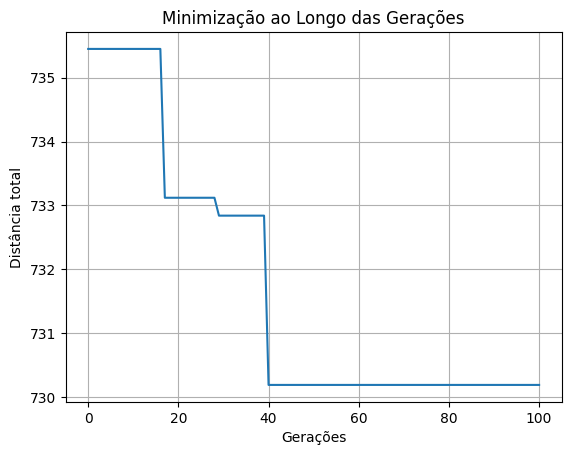

In [19]:
# Execução do algoritmo
melhores = alg_genetico(100, 70, 31, 5, 30, 0.15, 100, 10)

funcao = []
for item in melhores:
    try:
        f, c = item  # tenta desempacotar
        funcao.append(f)
    except TypeError:
        print(f"Erro ao desempacotar item: {item}, tipo: {type(item)}")

# Criação do gráfico de linhas
plt.plot(funcao)
plt.xlabel('Gerações')
plt.ylabel('Distância total')
plt.title('Minimização ao Longo das Gerações')
plt.grid(True)
plt.show()

In [20]:
round(((min(funcao) - 676.74) / 676.74) * 100, 2)

7.9

In [26]:
# Nome do arquivo CSV
arquivo_csv = 'melhores_resultados.csv'

# Valores da tupla min(funcao) que deseja adicionar
nota, cromossomo = min(melhores)

# Tentar abrir o arquivo CSV se ele existir, caso contrário criar um novo DataFrame
try:
    # Carregar o arquivo CSV existente
    df = pd.read_csv(arquivo_csv)
except FileNotFoundError:
    # Se o arquivo não existir, criar um DataFrame vazio com as colunas 'nota' e 'cromossomos'
    df = pd.DataFrame(columns=['Nota', 'Cromossomo'])

# Adicionar a nova linha ao DataFrame
novo_dado = pd.DataFrame([[nota, cromossomo]], columns=['Nota', 'Cromossomo'])
df = pd.concat([df, novo_dado], ignore_index=True)

# Salvar o DataFrame atualizado de volta no arquivo CSV
df.to_csv(arquivo_csv, index=False)

print(f"Nova linha adicionada: nota={nota}, cromossomos={cromossomo}")

Nova linha adicionada: nota=730.19, cromossomos=[[4, 7, 13, 3, 6, 9], [22, 17, 23, 2, 10, 27, 20], [29, 30, 5, 25, 18, 16, 21], [14, 15, 11, 24, 19, 1], [28, 8, 12, 26]]
